This notebook takes simulated quasar colors and DCR slopes.  Takes a single pointing from a single opSim and pretends that all quasars were observed at that point.  Then it simulates an "observation" in both the u and g band at every time of observation, including astrometric error.  Then it fits a line between the "observed" DCR offset and tan Z.  This slope is a function of redshift.  The slope determined from either 3 observations, 20 observations, or all the observations is compared to the "known" slope.

There is a lot of code that isn't necessary to do the above that can get cleaned up.  It would also be good to assign each quasar to a different position on the sky.  Also to enable this to sample many different opSims.

A potential metric could be found by taking 1-2 redshifts where the slope is close to 0 (DCR is not important) -- maybe where the u and g slopes are predicted to have opposite signs.  Then calculate the chi-square (or similar) for the slope determined from all of the observations for all the objects.  It should correlate highly with the number of u- and g-band observations and the airmass of those observations, which may perhaps lead to a simpler metric that doesn't actually involve DCR at all (at least directly).

In [1]:
import math
import astropy
from astropy.io import ascii
import numpy as np
import emcee
from scipy.optimize import minimize
from numpy.random import normal
from numpy.random import uniform
import matplotlib as mpl
import matplotlib.pyplot as plt
import palettable
import richardsplot as rplot
%matplotlib inline
import random
from matplotlib import rc
import pandas as pd
rc('text', usetex=False)

### open files with redshift bins, colors, and DCR slopes

In [2]:
#Table of redshift bins where we have computed the mean colors and DCR slopes.
zfile = 'fittingS82_zshifts.dat'
dfZ = pd.read_csv(zfile)
#dfZ.reset_index(drop=True)
dfZ

,zshifts
0,0.400
1,0.450
2,0.500
3,0.550
4,0.600
5,0.625
6,0.650
7,0.650
8,0.660
9,0.670


In [3]:
#Table of colors and DCR slopes for the above redshifts
datafile = 'fittingS82_zshiftfit.dat'
dfData = pd.read_csv(datafile, index_col=0, header=None, sep=' ').T
dfQSO = dfData.reset_index(drop=True).dropna()
#dfQSO.dropna()

In [4]:
dfDCR = pd.concat([dfZ, dfQSO], axis=1)
dfDCR.head()

,zshifts,u-g,g-r,r-i,i-z,u-slope,g-slope
0,0.40,0.3790,0.1143,0.1995,0.2466,0.0012,0.0258
1,0.45,0.2507,0.0644,0.2651,0.2032,0.0053,0.0506
2,0.50,0.2023,0.0410,0.2679,0.1762,0.0002,0.0589
3,0.55,0.3056,0.0252,0.2351,0.1314,-0.0140,0.0357
4,0.60,0.3419,0.0727,0.1867,0.1570,-0.0083,0.0143


In [5]:
dfDCR.tail()

,zshifts,u-g,g-r,r-i,i-z,u-slope,g-slope
461,3.80,2.1726,1.2433,0.1163,0.1022,-0.0215,-0.0186
462,3.85,1.7256,1.1350,0.1366,0.1582,-0.0029,-0.0126
463,3.90,1.8216,1.1345,0.1156,0.1389,0.0225,-0.0221
464,3.95,2.3703,1.3296,0.1086,0.0744,-0.0089,-0.0576
465,4.00,2.5010,1.4278,0.1483,0.0881,-0.0468,-0.0655


## open file with regression values

In [6]:
#BEE: create an array of sdss features
#BEE: read in table of regression values, create array of zeros with shape(features, redshifts)
#BEE: fill array of zeros with data from regression values table
#GTR: These are the mean colors and DCR slopes for the above redshift bins

sdss_features = ['u-g', 'g-r', 'r-i', 'i-z']
sdss_features_dcr = ['u-g', 'g-r', 'r-i', 'i-z', 'u-slope', 'g-slope']

color_fit_Table = ascii.read('fittingS82_zshiftfit.dat')
color_fit_Table.remove_column('col1')
color_fit = np.zeros((len(sdss_features), len(zshifts)))
color_fit_dcr = np.zeros((len(sdss_features_dcr), len(zshifts)))
for i in range(len(sdss_features)):
    for j in range(len(zshifts)):
        color_fit[i,j] = np.asarray(color_fit_Table[i][j])

for i in range(len(sdss_features_dcr)):
    for j in range(len(zshifts)):
        color_fit_dcr[i,j] = np.asarray(color_fit_Table[i][j])

## open file with regression covariance values

In [7]:
#BEE: read in regression covariance data
#BEE: create array of zeros with shape (features, features, redshifts), fill it with covariance table data
#GTR: These are the covariances between each of the above parameters at each redshift

color_covariance_Table = ascii.read('fittingS82_zshiftcovariance.dat')
color_covariance_Table.remove_column('col1')
color_covariance_Table.remove_column('col2')
color_covariance = np.zeros((len(sdss_features), len(sdss_features), len(zshifts)))
color_covariance_dcr = np.zeros((len(sdss_features_dcr), len(sdss_features_dcr), len(zshifts)))  
l = 0
for i in range(len(sdss_features_dcr)):
    for j in range(len(sdss_features_dcr)):
        for k in range(len(zshifts)):
            color_covariance_dcr[i,j,k] = np.asarray(color_covariance_Table[l][k])
        l += 1
color_covariance = color_covariance_dcr[:4, :4, :]
#print(color_covariance_dcr)
#print(color_covariance)

## open file with the simulated quasar true values

In [8]:
#BEE: Read in simulated "true" quasar data
#GTR: These are simulated quasars with simulated parameters (and their errors)

Replace test_quasars with dfQSO

test_quasars0 = ascii.read('random_quasars.dat')
test_quasars = ascii.read('random_quasars100k.dat')[:1000]
print(test_quasars.keys())

print(test_quasars)

## define the observations

In [9]:
#BEE: simulate airmass observations in u ang g
#GTR: We ignore the next cell?

astrometric_error = [0.035,0.025]  #[u-band error, g-band error]

airmasses = uniform(low=1.0, high=1.3, size=50)
airmasses = np.append(airmasses, uniform(low=1.3, high=2.0, size=14))

filters = np.tile(['u', 'g'], int(len(airmasses)/2))

In [10]:
#BEE: this cell will take observations from the OpSim rather than simulating them
#GTR: Not sure exactly where this opSim information comes from.  Weixiang?
#id.csv is just an indexed list of RA and Dec
#dcr_all.csv is a list of observation parameters for each of those IDs
#this includes airmass and filter, which is all that we use right now?
#It seems that right now a random object is being chosen?

The next cell sets the astrometric error in the u and g bands.  This needs to be changed for different simulated magnitudes.

In [11]:
astrometric_error = [0.035, 0.025]
#astrometric_error = np.multiply(astrometric_error, [2,2])
print(astrometric_error)

[0.035, 0.025]


This next cell needs to be changed.  It should instead assign each of the redshifts above to a random position on the sky using a real opSim.  Ideally more like each redshift gets ~100 random positions.  

Hoping that Weixiang can help with that.  For now, just using the one random position once for each redshift.

In [12]:
# Weixiang: import opsim cadence after fix for python2
ids = pd.read_csv('id.csv')
cad = pd.read_csv('dcr_all.csv')

#pick random object's cadence
random_cadence = random.randint(0,max(cad['id']))
# assign the cadence of random object to dcr_0
dcr_0 = cad[cad['id'] == random_cadence].copy()
obs_g = dcr_0[dcr_0['filter'] == 'g']
obs_u = dcr_0[dcr_0['filter'] == 'u']
obs = np.concatenate((obs_g, obs_u))

### Orginal code to import cadence
# dcr = np.load('dcr.npz')
# print(list(dcr.keys()))
# dcrra_dec = dcr['ra_dec']
# dcrdata = dcr['data']
# print(dcrra_dec[0])
# obs_g = dcrdata[0][dcrdata[0]['filter']=='g']
# obs_u = dcrdata[0][dcrdata[0]['filter']=='u']
# obs = np.concatenate((obs_g, obs_u))

GTR: (24 July 2020) I don't recall what these comments are about.  Should take another look at them.

GTR: Split out cell that defines airmasses.  Just define one at a time.  Predefine the experiments and comment out the ones being run each time.  Make sure that the output files are unique for each experiment.

GTR: Run colors only and colors+normal DCR just once.  We don't need to run those again.  But those can be the first 2 "experiments".

In [13]:
#GTR: Extract the airmass and filters for each observation

In [14]:
# Weixiang: modified the item index to match the order of columns in new file
airmasses = np.array([item[3] for item in obs])
filters = np.array([item[5] for item in obs])

#airmasses_long = np.append(airmasses, [1.6, 1.6])
#filters_long = np.append(filters, ['g', 'g'])
#airmasses_twilight = np.append(airmasses, [2.0, 2.0])
#filters_twilight = np.append(filters, ['g', 'g'])

BEE: The next cell is a switch that lets you choose the experiment to run.  There are 2 types of experiments: 'substitution' and 'addition'.  Change the string in the cell to either 'substitution' or 'addition'.  The airmasses should be 1.6, 1.7, 1.8, 1.9, or 2.0.  In the case of addition, you can set airmass_to_use to an array of airmasses and it will add all of them.  NOTE: Make sure, if you're running multiple experiments, to run the cell above for each one so you don't overwrite the wrong airmasses array.

In [15]:
#GTR: Let's not do that experiment any more and just explore the different opSims.  
#So either take this out or just leave the array blank.

experiment_to_run = 'addition'
#experiment_to_run = 'substitution'
#experiment_to_run = 'addition'
airmass_to_use = []

if experiment_to_run == 'colors':
    save_file_name = 'AstroMetric_Colors_noDCR.npz'

if experiment_to_run == 'substitution':    
    airmass_to_substitute = airmass_to_use[0]
    index_of_lowest = np.argmin(airmasses)
    airmasses[index_of_lowest] = airmass_to_substitute
    save_file_name = 'AstroMetric_SubstitutionDCR_' + str(int(airmass_to_substitute*10)) + '.npz'

if experiment_to_run == 'addition':
    filters_to_add = np.tile('g', int(len(airmass_to_use)))
    airmasses = np.append(airmasses, airmass_to_use)
    filters = np.append(filters, filters_to_add)
    save_file_name = 'AstroMetric_TwilightDCR_' + str([int(airmass_to_use[i]*10) for i in range(len(airmass_to_use))]) + '.npz'

In [16]:
#GTR: Not sure why this is here
#and not clear that this file name is being used
#I think that Bee was just trying to compare the results after 20 and 3 observations.

#airmass removal cell
print(len(airmasses))
#if you don't want to remove any, set number_to_leave to "all"
number_to_leave = 20
number_to_leave="all"
if number_to_leave != "all":
    save_file_name = save_file_name[:-4] + "_" + str(number_to_leave) + "obs" + save_file_name[-4:]
    print("file name is " + save_file_name)
    number_to_remove = len(airmasses) - number_to_leave
else:
    number_to_remove = 0
removed = 0
while removed < number_to_remove:
    remove_index = random.randint(0,len(airmasses)-1)
    airmasses = np.delete(airmasses, remove_index)
    filters = np.delete(filters, remove_index)
    removed += 1 

In [18]:
save_file_name = "testfile.npz"

In [19]:
print(len(airmasses))
print(airmasses)
print(filters)
print(save_file_name)

277
[1.1726947  1.14964866 1.14665071 1.15514543 1.14492042 1.14872145
 1.14515035 1.1450416  1.14468107 1.17426026 1.14750543 1.19435175
 1.15907846 1.14394105 1.14818688 1.14507252 1.1474348  1.17551552
 1.14450247 1.14449154 1.14749305 1.16613397 1.14415522 1.14777321
 1.14453    1.14476049 1.15975295 1.15606078 1.1615167  1.1451261
 1.15826606 1.14520899 1.15475906 1.14566176 1.15486334 1.14878376
 1.18396863 1.16518179 1.15176908 1.14991857 1.15084934 1.14540538
 1.14471777 1.14799172 1.14650953 1.14473775 1.14926382 1.14432427
 1.17152787 1.14659073 1.17571806 1.19339059 1.15040115 1.19277165
 1.19856944 1.15779416 1.14671671 1.16507073 1.15920488 1.14495106
 1.15798801 1.15384632 1.1535629  1.14471068 1.15105304 1.20715578
 1.17474014 1.18034446 1.14421024 1.14837775 1.21187912 1.15344614
 1.14524301 1.14561887 1.19013858 1.14876672 1.15383535 1.14934256
 1.15720585 1.14493182 1.15789288 1.19715527 1.1760139  1.1807019
 1.18508633 1.18546044 1.19939574 1.1776499  1.17730025 1.18

In [25]:
#GTR: I think that this is just to provide a basis of comparison with just a few (here 3) epochs.

airmasses_20 = airmasses
filters_20 = filters
if experiment_to_run == 'addition':
    filters_to_add = np.tile('g', int(len(airmass_to_use)))
    airmasses = np.append(airmasses, airmass_to_use)
    filters = np.append(filters, filters_to_add)
    save_file_name = 'AstroMetric_TwilightDCR_' + str([int(airmass_to_use[i]*10) for i in range(len(airmass_to_use))]) + '.npz'
number_to_leave = 3
if number_to_leave != "all":
    save_file_name = save_file_name[:-4] + "_" + str(number_to_leave) + "obs" + save_file_name[-4:]
    print("file name is " + save_file_name)
    number_to_remove = len(airmasses) - number_to_leave
else:
    number_to_remove = 0
removed = 0
while removed < number_to_remove:
    remove_index = random.randint(0,len(airmasses)-1)
    airmasses = np.delete(airmasses, remove_index)
    filters = np.delete(filters, remove_index)
    removed += 1 
airmasses_3 = airmasses
filters_3 = filters


## generate observed slopes from true slopes and observations

In [27]:
#BEE: lnlike calculates the loglikelihood, lnprior creates a prior on our linear fits, lnprob adds the prior to lnlike
#BEE: run_fit runs the mcmc walkers over a range of linear fits and selects the median as the best fit and half the 
#     difference between 16th and 84th percentiles as the error
#GTR: run_fit is computing the slope in the offset vs. tanZ plane for a single object

In [23]:
def lnlike(theta, x, y, yerr):
    m, lnf = theta
    model = m*x
    inv_sigma2 = 1.0/(yerr**2. + model**2.*np.exp(2.*lnf))
    return -0.5*(np.sum(((y-model)**2.*inv_sigma2 - np.log(inv_sigma2))))

def lnprior(theta):
    m, lnf = theta
    if (-1.0 < m < 1.0) and (-100.0 < lnf < 100.0):
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

def run_fit(tanZList, RList, RerrList):
    nll = lambda *args: -lnprob(*args)
    x = np.copy(tanZList)
    y = np.copy(RList)
    yerr = np.copy(RerrList)
    #first do a simple minimization to get starting values for mcmc
    pm = np.random.choice([-1.0,1.0], size=len(x), replace=True)
    result = minimize(nll, [-0.001, np.log(0.5)], args=(x, y, yerr))
    m_ml, lnf_ml = result["x"]
    #now run mcmc
    ndim, nwalkers = 2, 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
    sampler.run_mcmc(pos, 500)
    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
    ms = samples[np.random.randint(len(samples), size=100)][:,0]
    # return the median walker as the best slope and the half the 16-84th percentiles as the error
    m_mcmc, lnf_mcmc = map(lambda v: (v[1]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
    merr_mcmc, lnf_mcmc = map(lambda v: (0.5*(v[2]-v[0])), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
    return m_mcmc, merr_mcmc

GTR: Split out cells that define functions from cells that make calls to those functions.

In [29]:
#GTR: dcrSlopeCalc is computing the slope in the offset vs. tanZ plane for all the objects, calling run_fit for each

In [26]:
def dcrSlopeCalc(airmasses, filters, test_quasars, makePlot = True):
    #Note that the next line overrides the cell above!!
    astrometric_error = [0.035, 0.025]
    obs_slopes_u    = np.zeros((len(test_quasars)))
    obs_slopes_uerr = np.zeros((len(test_quasars)))
    obs_slopes_g    = np.zeros((len(test_quasars)))
    obs_slopes_gerr = np.zeros((len(test_quasars)))
    imgNumString = 0
    xAxis = np.linspace(0, 2.0, 100)
    for i in range(len(test_quasars)):
        true_slope_u = test_quasars['u-slope'][i]
        true_slope_g = test_quasars['g-slope'][i]
    
        tanZList_u = np.array([])
        RerrList_u = np.array([])
        RList_u = np.array([])
        tanZList_g = np.array([])
        RerrList_g = np.array([])
        RList_g = np.array([])
    
        for j, airmass in enumerate(airmasses):
            tanZ_obs = np.tan(np.arccos(1.0/airmass)) #tangent of zenith angle of this observation
            if filters[j] == 'u':
                #calculate the observed offset
                #random scatter around the true offset using a normal distribution with the astrometric error as the standard deviation
                R_obs = normal(true_slope_u*tanZ_obs, astrometric_error[0])
                tanZList_u = np.append(tanZList_u, tanZ_obs)              #list of x axis values
                RerrList_u = np.append(RerrList_u, astrometric_error[0])  #list of y axis error values
                RList_u = np.append(RList_u, R_obs)                       #list of y axis values
            if filters[j] == 'g':
                R_obs = normal(true_slope_g*tanZ_obs, astrometric_error[1])
                tanZList_g = np.append(tanZList_g, tanZ_obs)
                RerrList_g = np.append(RerrList_g, astrometric_error[1])
                RList_g = np.append(RList_g, R_obs)
    
        # fit a stright line through the x and y values, using the y-err values
        m_mcmc_u, merr_mcmc_u = run_fit(tanZList_u, RList_u, RerrList_u)
        m_mcmc_g, merr_mcmc_g = run_fit(tanZList_g, RList_g, RerrList_g)
        if makePlot == True:
            bestFitLine_u = m_mcmc_u*xAxis + 0.0
            bestFitLine_g = m_mcmc_g*xAxis + 0.0
            trueFitLine_u = true_slope_u*xAxis + 0.0
            trueFitLine_g = true_slope_g*xAxis + 0.0
            plt.figure(figsize=(12,12))
            plt.subplot(121)
            plt.title('u-band observations + fit')
            plt.scatter(tanZList_u, RList_u, label = 'Observations')
            plt.plot(xAxis, bestFitLine_u, label='Fit Line')
            plt.plot(xAxis, trueFitLine_u, label = 'True Line')
            plt.legend()
            plt.xlabel('Tan(Z)')
            plt.ylabel('delta R')
            plt.xlim(0.0, 2.0)
            plt.scatter(x=tanZList_u, y=RList_u)
            plt.subplot(122)
            plt.title('g-band observations + fit')
            plt.scatter(tanZList_g, RList_g, label = 'Observations')
            plt.plot(xAxis, bestFitLine_g, label = 'Fit Line')
            plt.plot(xAxis, trueFitLine_g, label = 'True Line')
            plt.xlabel('Tan(Z)')
            plt.xlim(0.0, 2.0)
            plt.scatter(x=tanZList_g, y=RList_g)
            filename = "TanZimgFiles/airmassOffsetFit"+str(len(airmasses))+"_"+"{:0>5d}".format(imgNumString)
            plt.savefig(filename)
            plt.clf()
            plt.close()
            imgNumString += 1
        obs_slopes_u[i] = m_mcmc_u
        obs_slopes_uerr[i] = merr_mcmc_u
        obs_slopes_g[i] = m_mcmc_g
        obs_slopes_gerr[i] = merr_mcmc_g
    if makePlot == True:
        deltaSlope_u = []
        deltaSlope_g = []
        for i in range(len(obs_slopes_u)):
            deltaSlope_u = np.append(deltaSlope_u, test_quasars['u-slope'][i] - obs_slopes_u[i])
        for i in range(len(obs_slopes_g)):
            deltaSlope_g = np.append(deltaSlope_g, test_quasars['g-slope'][i] - obs_slopes_g[i])
        plt.figure(figsize=(12,12))
        plt.subplot(121)
        plt.hist(deltaSlope_u, bins=50, range=(-0.3,0.3))
        plt.title('Delta Slope u-band '+str(len(airmasses)))
        plt.subplot(122)
        plt.hist(deltaSlope_g, bins=50, range=(-0.3,0.3))
        plt.title('Delta Slope g-band '+str(len(airmasses)))
        filename = "DeltaSlopeimgFiles/deltaSlopeHist" + str(len(airmasses))
        plt.savefig(filename)
    return obs_slopes_u, obs_slopes_uerr, obs_slopes_g, obs_slopes_gerr

In [31]:
#GTR: This cell actually calls the code that computes the slopes
#This is taking every object in the test set and treating them as if they were observed at the same position
#on the sky from the simulation.  That's why the number of airmasses is the same.  Some of them are u and
#some are g.

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


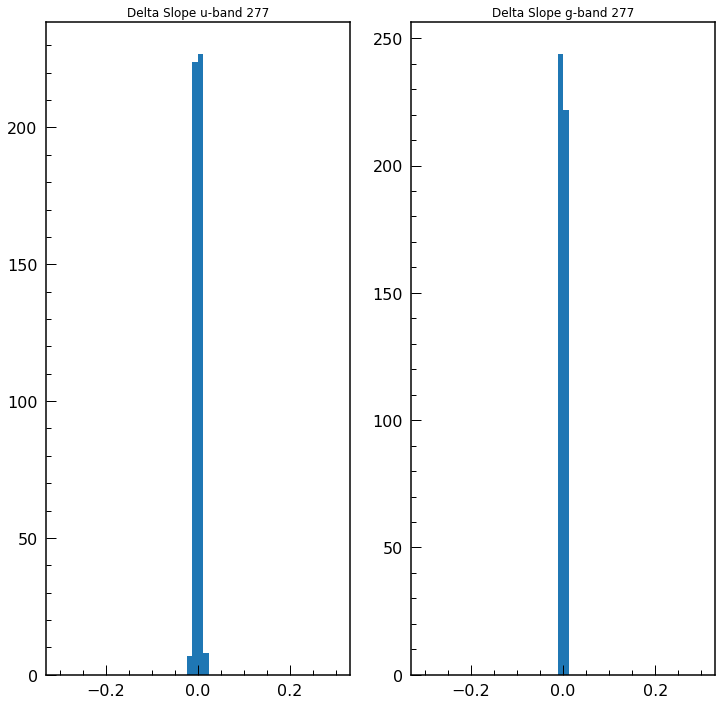

In [27]:
obs_slopes_u, obs_slopes_uerr, obs_slopes_g, obs_slopes_gerr = dcrSlopeCalc(airmasses, filters, dfQSO, makePlot=False)

Text(0.5, 0, 'Redshift')

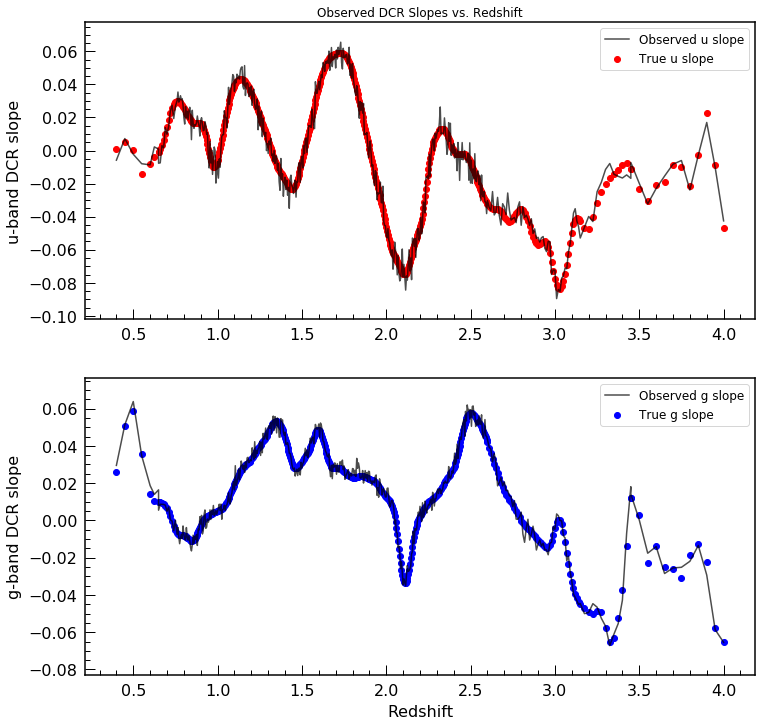

In [33]:
sort_indices = np.argsort(dfDCR['zshifts'])
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.title('Observed DCR Slopes vs. Redshift')
plt.scatter(dfDCR['zshifts'][sort_indices], dfDCR['u-slope'][sort_indices], color='red', label = 'True u slope')
plt.plot(dfDCR['zshifts'][sort_indices], obs_slopes_u[sort_indices], color='black', label = 'Observed u slope', alpha=0.7)
plt.legend(loc='upper right')
plt.ylabel('u-band DCR slope')
plt.subplot(212)
plt.scatter(dfDCR['zshifts'][sort_indices], dfDCR['g-slope'][sort_indices], color='blue', label = 'True g slope')
plt.plot(dfDCR['zshifts'][sort_indices], obs_slopes_g[sort_indices], color='black', label = 'Observed g slope', alpha=0.7)
plt.legend(loc='upper right')
plt.ylabel('g-band DCR slope')
plt.xlabel('Redshift')


obs_slopes_u_20, obs_slopes_uerr, obs_slopes_g_20, obs_slopes_gerr = dcrSlopeCalc(airmasses_20, filters_20, test_quasars)
obs_slopes_u_3, obs_slopes_uerr, obs_slopes_g_3, obs_slopes_gerr = dcrSlopeCalc(airmasses_3, filters_3, test_quasars)


Text(0.5, 0, 'Redshift')

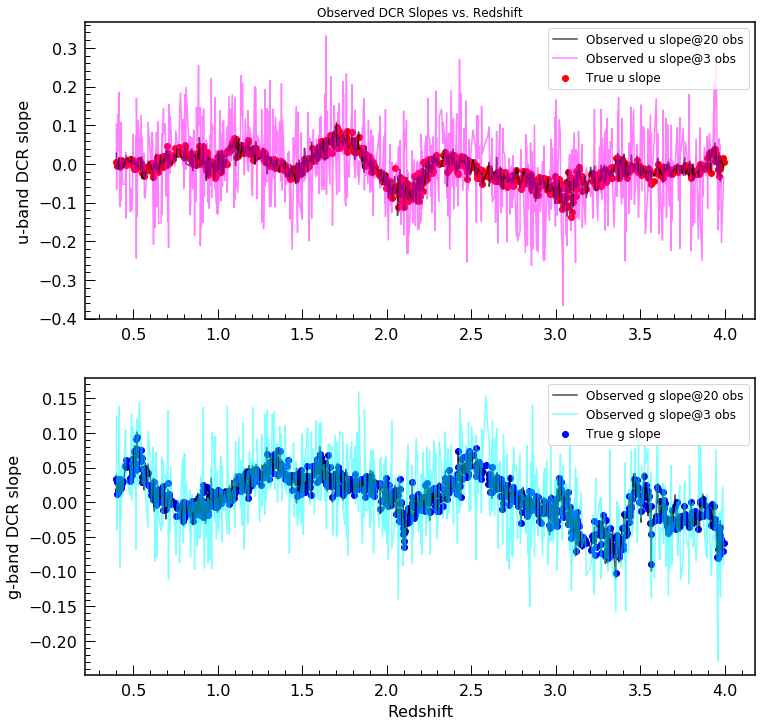

In [33]:
sort_indices = np.argsort(test_quasars['zspec'])
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.title('Observed DCR Slopes vs. Redshift')
plt.scatter(test_quasars['zspec'][sort_indices], test_quasars['u-slope'][sort_indices], color='red', label = 'True u slope')
plt.plot(test_quasars['zspec'][sort_indices], obs_slopes_u_20[sort_indices], color='black', label = 'Observed u slope@20 obs', alpha=0.7)
plt.plot(test_quasars['zspec'][sort_indices], obs_slopes_u_3[sort_indices], color='magenta',alpha=0.5, label = 'Observed u slope@3 obs')
plt.legend(loc='upper right')
plt.ylabel('u-band DCR slope')
plt.subplot(212)
plt.scatter(test_quasars['zspec'][sort_indices], test_quasars['g-slope'][sort_indices], color='blue', label = 'True g slope')
plt.plot(test_quasars['zspec'][sort_indices], obs_slopes_g_20[sort_indices], color='black', label = 'Observed g slope@20 obs', alpha=0.7)
plt.plot(test_quasars['zspec'][sort_indices], obs_slopes_g_3[sort_indices],color='cyan', alpha=0.5, label = 'Observed g slope@3 obs')
plt.legend(loc='upper right')
plt.ylabel('g-band DCR slope')
plt.xlabel('Redshift')


In [ ]:
#GTR: I have ignored everything past here.
#I was more concerned about making sure that we could reproduce the above plot.


## calculate redshift PDFs for observed quasars

In [28]:
def calculate_PDFs(parameters, zshifts, feature_zshift_fit, feature_covariance):
    
    num_features = int((np.shape(parameters)[0]-1)/2)
    num_of_quasars = np.shape(parameters)[1]
    
    #empty arrays to be filled
    feature_distance =  np.zeros((num_of_quasars, num_features, len(zshifts)))
    prob = np.zeros((num_of_quasars, len(zshifts)))
    chi_squared =  np.zeros((num_of_quasars, len(zshifts)))
    for i in range(num_of_quasars):
        #empty arrays to be filled
        features = np.zeros((num_features))
        covariance_matrix_of_features = np.zeros((num_features,num_features))
        
        # loop through all the features (e.g. 'u-g', 'g-r', 'r-i', 'i-z', 'u-slope', 'g-slope')
        for j in range(num_features):
            for k in range(num_features):
                if (j == k):
                    if j < 4:
                        # covaraince between the colors, on the diagonal
                        covariance_matrix_of_features[j,k] = parameters[j+num_features,i]**2.0 + parameters[j+num_features+1,i]**2.0
                    else:
                        # covaraince between the slopes, on the diagonal
                        covariance_matrix_of_features[j,k] = parameters[j+num_features+1,i]**2.0
                elif abs(j - k) == 1:
                    if j > k:
                        if j < 4:
                            # covaraince between the colors, just off the diagonal
                            covariance_matrix_of_features[j,k] = -1.0*parameters[j+num_features,i]**2.0
                    if k > j:
                        if k < 4:
                            # covaraince between the slopes, just off the diagonal
                            covariance_matrix_of_features[j,k] = -1.0*parameters[k+num_features,i]**2.0
            # difference between the features of this quasar and the regression calculate for all the quasars
            features[j] = parameters[j,i]
            feature_distance[i,j,:] = np.abs(features[j] - feature_zshift_fit[j,:])
        for z in range(len(zshifts)):
            # linear algebra from Weinstein et al. 2004
            A = np.matrix(feature_distance[i,:,z])
            B = np.matrix(covariance_matrix_of_features[:,:])
            C = np.matrix(feature_covariance[:,:,z])
            chi_squared[i,z] = np.dot(np.dot(A, (B + C).I), A.T)
            try:
                prob[i,z] = (np.exp(-1.0*chi_squared[i,z]/2.0))/(4.0*(math.pi**2.0)*(np.linalg.det(B + C)**0.5))
                #if np.isnan(prob[i,z]):
                    #prob[i,z] = 1e-250
                    #prob[i,z] = (np.finfo(np.float64).tiny)
            except:
                prob[i,z] = 0.0
        # normalize the probabilities
        sum_of_array = np.nansum(prob[i,:], axis=0, dtype=np.float64)
        try:
            prob[i,:] = prob[i,:]/sum_of_array
        except:
            prob[i,:] = 0.0*prob[i,:]
    return prob

In [29]:
#calculate the pdf of the redshift
if experiment_to_run != 'colors':
    obs_photoz_PDFs = calculate_PDFs(obs_parameters, zshifts, color_fit_dcr, color_covariance_dcr)
else:
    obs_photoz_PDFs = calculate_PDFs(obs_parameters, zshifts, color_fit, color_covariance)
'''
#dcr of opsim alone pdf
obs_photoz_PDFs_dcr1 = calculate_PDFs(obs_parameters_dcr1, zshifts, color_fit_dcr, color_covariance_dcr)
#dcr of opsim+longer observation time
obs_photoz_PDFs_dcr2 = calculate_PDFs(obs_parameters_dcr2, zshifts, color_fit_dcr, color_covariance_dcr)
#dcr of opsim+twilight survey
obs_photoz_PDFs_dcr3 = calculate_PDFs(obs_parameters_dcr3, zshifts, color_fit_dcr, color_covariance_dcr)
'''

NameError: name 'obs_parameters' is not defined

## calculate the peaks of the redshift PDFs

In [ ]:
def photozPDF_to_pointestimate(photoz_PDFs, zshifts):
    prob_threshold = 1.0/len(photoz_PDFs[0,:]) #threshold is above if all the probability were equally distributed
    num_of_quasars = len(photoz_PDFs[:,0])
    photoz_peaks = np.zeros((num_of_quasars))
    for i in range(num_of_quasars):
        zpeaks = np.array([])
        zprobs = np.array([])
        # all the non-nan values
        good_idxs = np.arange(len(photoz_PDFs[i,:]), dtype=np.int)[~np.isnan(photoz_PDFs[i,:])]
        # all the non-nan values above the probability threshold
        good_idxs_high = good_idxs[np.where(photoz_PDFs[i,:][~np.isnan(photoz_PDFs[i,:])] > prob_threshold)[0]]
        above_prob_threshold = list(good_idxs_high)
        # only find peaks if there is a value above the threshold
        if len(above_prob_threshold[1:-1]) > 1:
            # find all the contiguous bins above the probability threshold, these are the bumps in the PDF
            ranges = sum((list(t) for t in zip(above_prob_threshold, above_prob_threshold[1:]) if t[0]+1 != t[1]), [])
            # add the edges of the redshift range back on
            iranges = above_prob_threshold[0:1] + ranges + above_prob_threshold[-1:]
            # find the peak of each of the bumps
            for peaks in range(int(len(iranges)/2)):
                peak_zmin = iranges[int(peaks*2):int(peaks*2) + 2][0]
                peak_zmax = iranges[int(peaks*2):int(peaks*2) + 2][1]
                peak_maxprob = zshifts[peak_zmin:peak_zmax+1][np.argmax(photoz_PDFs[i,peak_zmin:peak_zmax+1])]
                # only count the peak if it isn't the minimum or maximum redshift bin
                # there can be weird edge effects in the PDFs, so we don't want those peaks
                if (peak_maxprob != zshifts[0]) and (peak_maxprob != zshifts[-1]):
                    zpeaks = np.append(zpeaks, peak_maxprob)
                    # the probability of that peak is all the area under the bump
                    zprobs = np.append(zprobs, np.sum(photoz_PDFs[i,peak_zmin:peak_zmax+1]))
                else:
                    zpeaks = np.append(zpeaks, peak_maxprob)
                    zprobs = np.append(zprobs, 0.0)
            photoz_peaks[i] = zpeaks[np.argmax(zprobs)]
        else:
            photoz_peaks[i] = np.nan
    return photoz_peaks

In [ ]:
obs_photoz_peaks = photozPDF_to_pointestimate(obs_photoz_PDFs, zshifts)
#obs_photoz_peaks_dcr1 = photozPDF_to_pointestimate(obs_photoz_PDFs_dcr1, zshifts)
#obs_photoz_peaks_dcr2 = photozPDF_to_pointestimate(obs_photoz_PDFs_dcr2, zshifts)
#obs_photoz_peaks_dcr3 = photozPDF_to_pointestimate(obs_photoz_PDFs_dcr3, zshifts)
print(obs_photoz_peaks)

## Save Experiment

In [ ]:
fileName = save_file_name
test_quasars_zspec = test_quasars['zspec']
if experiment_to_run != 'colors':
    np.savez(fileName, 
             airmasses=airmasses,
             filters=filters,
             deltaSlope_g=deltaSlope_g, 
             deltaSlope_u=deltaSlope_u, 
             z_phot=obs_photoz_peaks,
             z_true=test_quasars_zspec,
             redshift=zshifts)
else:
    np.savez(fileName,
            z_phot = obs_photoz_peaks,
            z_true = test_quasars_zspec,
            redshift=zshifts)

## write out the simulated quasars

In [ ]:
test_quasars_zspec = test_quasars['zspec']

with open('simulatedquasars_photozPDFs.dat', "w") as file_name:
    file_name.write("#zspec photozpeak photozPDF")
    file_name.write("\n")
    for i in range(len(test_quasars_zspec)):
        file_name.write("%0.4f %0.4f " % (test_quasars_zspec[i], obs_photoz_peaks[i]))
        for j in range(len(obs_photoz_PDFs[i,:])):
            file_name.write("%0.4f " % (obs_photoz_PDFs[i,j]))
        file_name.write("\n")

with open('simulatedquasars_obsparameters.dat', "w") as file_name:
    file_name.write("#zspec u-g g-r r-i i-z u-slope g-slope uerr gerr rerr ierr zerr u-slopeerr g-slopeerr")
    file_name.write("\n")
    for i in range(len(test_quasars_zspec)):
        for j in range(len(obs_parameters[:,i])):
            file_name.write("%0.4f " % (obs_parameters[j,i]))
        file_name.write("\n")

GTR: Have everything below read in data files in order to produce plots.  Let's just make single panels instead of 2x2.  We can build those if need be.

GTR: Add z_spec vs. zphot plots and Delta z histograms

## calculate the redshift quality metric

In [ ]:
def photo_z_robust_stdev(z_est, z_true, zshifts):
    """
    Sort the delta_z data into redshift bins in z_true.
    Delta_z is defined as (z_true - z_est) / (1. + z_true).
    
    Calculate the robust standard deviation in each bin as a function of true redshift.
    Robust standard deviation is defined as the standard deviation of delta_z in the bin where delta_z
    is defined as (z_true - z_est) / (1. + z_true) and we trim the highest and lowest 25% of delta_z values.
    """

    delta_z = (z_true - z_est) / (1. + z_true)
    idx_sort = z_true.argsort()
    delta_z_sort = delta_z[idx_sort]
    z_true_sort = z_true[idx_sort]
    idx_bins = z_true_sort.searchsorted(zshifts)
    delta_z_binned = [delta_z_sort[idx_bins[i]:idx_bins[i+1]] for i in range(len(zshifts)-1)]
    stdev_iqr_results = []
    for delta_z_data in delta_z_binned:
        if len(delta_z_data) == 0:
            stdev_iqr_results.append(np.nan)
            continue
        bin_25 = np.percentile(delta_z_data, 25.)
        bin_75 = np.percentile(delta_z_data, 75.)
        diff = bin_75 - bin_25
        stdev_iqr_results.append(diff/1.349)
    return np.array(stdev_iqr_results)

## Load in Save File

In [ ]:
#put the name of the file you want to plot from here
#file_to_load = 'this_is_a_placeholder.npz'  #Defaults to file that was just created, but can be changed
file_to_load = save_file_name
#file_to_load = "AstroMetric_TwilightDCR_[]_2obs.npz"
plot_data = np.load(file_to_load)
print(file_to_load[:-4])

In [ ]:
#calculate standard deviation of zphot over the interquartile range
stdev_iqr = photo_z_robust_stdev(plot_data['z_phot'], plot_data['z_true'], plot_data['redshift'])

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[10,10])
plt.xlabel('True Redshift')
plt.ylabel('Standarad Deviation within Interquartile Range')
plt.xlim(0.3,4)
plt.ylim(0,0.4)
plt.scatter(plot_data['redshift'][:-1], stdev_iqr)
plot_save_name = file_to_load[:-4] + '_stdev_iqr_plot.pdf'
plt.savefig(plot_save_name)

In [ ]:
plt.figure(figsize=[10,10])
plt.xlabel('True Redshift')
plt.ylabel('Zphot')
plt.scatter(plot_data['z_true'], plot_data['z_phot'])
plot_save_name = file_to_load[:-4] + '_ztrue_vs_zphot_plot.pdf'
plt.savefig(plot_save_name)

In [ ]:
deltaZ = np.subtract(plot_data['z_true'], plot_data['z_phot'])
data, bin_edges = np.histogram(deltaZ, bins='fd')
bins = 0.5*(bin_edges[:-1]+bin_edges[1:])
#z_err = np.divide(deltaZ, [1+z for z in plot_data['z_true']])
plt.figure(figsize=[10,10])
plt.xlabel('deltaZ')
plt.ylabel('Counts')
plt.step(bins,data)
plot_save_name = file_to_load[:-4] + '_deltaZ_hist_plot.pdf'
plt.savefig(plot_save_name)

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.hist(plot_data['deltaSlope_u'], bins=75, range=(-0.3,0.3))
plt.title('Delta Slope u-band '+str(len(plot_data['airmasses'])))
plt.subplot(122)
plt.hist(plot_data['deltaSlope_g'], bins=75, range=(-0.3,0.3))
plt.title('Delta Slope g-band '+str(len(plot_data['airmasses'])))
filename = "DeltaSlopeimgFiles/deltaSlopeHist" + str(len(plot_data['airmasses']))
plt.savefig(filename)